In [1]:
import sys
sys.path.append('F:\\pythonproject\\Tensor\\Chunk_v2\\')
import Chunk
print(Chunk.__file__)
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

F:\pythonproject\Tensor\Chunk_v2\Chunk\__init__.py


In [2]:
expr_df = pd.read_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\data\\LUAD\\TCGA-LUAD_tpm.csv', header=0, index_col=0).T #samples as rows and genes as columns

In [3]:
clin_df = pd.read_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\data\\LUAD\\TCGA-LUAD_survival.csv', index_col=0, header=0)

In [4]:
S = Chunk.getProgConstraint(clin_df,interest =1)#0 means focus on good progonosis

In [5]:
lr_expr_pairs, lr_expr_df = Chunk.filter_Bulkdata(expr_df,threshold=1,log=False)

In [6]:
comm_matrix2 = Chunk.build_communication_matrix(lr_expr_pairs, lr_expr_df)

In [ ]:
optimal_K = Chunk.select_k_nmf(
    comm_matrix2.T.values.astype(float), S, k_max=20, repeat_times=5, verbose=True, 
    use_semi_supervised=True,
    semi_supervised_params={"alpha": 0.01, "beta": 0.01, "rho": 0.75}
)
print(f"Recommended K: {optimal_K}")

In [9]:
W, H, loss_history = Chunk.LRcommMining(X = comm_matrix2.T.values.astype(float), S=S, n_components=optimal_K, alpha=0.01, beta=0.01, rho=0.75, maxiter=8000, lr=0.001)

D:\python\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


Iteration 0/8000, Loss: 443325.5312
Iteration 50/8000, Loss: 442563.4375
Iteration 100/8000, Loss: 441931.9062
Iteration 150/8000, Loss: 441381.8750
Iteration 200/8000, Loss: 440884.9062
Iteration 250/8000, Loss: 440432.9375
Iteration 300/8000, Loss: 440018.9375
Iteration 350/8000, Loss: 439634.2812
Iteration 400/8000, Loss: 439275.8438
Iteration 450/8000, Loss: 438943.7812
Iteration 500/8000, Loss: 438634.3750
Iteration 550/8000, Loss: 438350.1250
Iteration 600/8000, Loss: 438085.9375
Iteration 650/8000, Loss: 437838.0312
Iteration 700/8000, Loss: 437605.1250
Iteration 750/8000, Loss: 437389.5625
Iteration 800/8000, Loss: 437185.4062
Iteration 850/8000, Loss: 436993.0938
Iteration 900/8000, Loss: 436815.6250
Iteration 950/8000, Loss: 436649.0312
Iteration 1000/8000, Loss: 436494.1562
Iteration 1050/8000, Loss: 436350.5938
Iteration 1100/8000, Loss: 436219.7188
Iteration 1150/8000, Loss: 436102.2812
Iteration 1200/8000, Loss: 435997.0938
Iteration 1250/8000, Loss: 435901.9688
Iteration

In [8]:
phenotype_types = {
    "completerank": "continuous",
}

result = Chunk.Singleassociationanalysis(W, clin_df, phenotype_types)

In [9]:
result#the negative Coefficient mean related to good prognosis

Phenotype        Mode  Coefficient       P_value  R_squared  \
0  completerank   Pattern_1     0.000965  9.618370e-01   0.000004   
1  completerank   Pattern_2    -0.011558  3.766896e-01   0.001362   
2  completerank   Pattern_3     0.050647  1.028817e-02   0.011415   
3  completerank   Pattern_4    -0.022928  4.171522e-01   0.001147   
4  completerank   Pattern_5     0.040058  7.095333e-02   0.005670   
5  completerank   Pattern_6    -0.031627  1.967547e-01   0.002901   
6  completerank   Pattern_7    -0.007824  8.362808e-01   0.000074   
7  completerank   Pattern_8    -0.076528  1.293825e-02   0.010714   
8  completerank   Pattern_9    -0.008780  1.097720e-01   0.004450   
9  completerank  Pattern_10     0.114050  2.795614e-07   0.044966   

   Adjusted_P_value  
0          0.961837  
1          0.521440  
2          0.043127  
3          0.521440  
4          0.177383  
5          0.327924  
6          0.929201  
7          0.043127  
8          0.219544  
9          0.000003

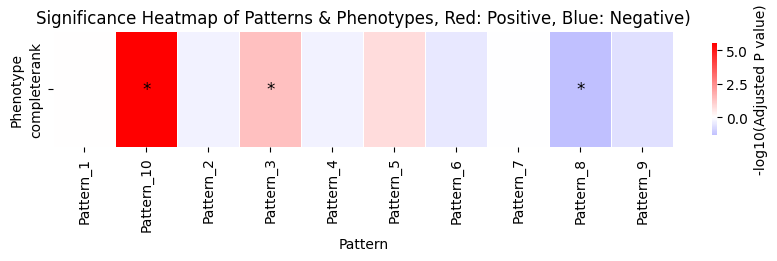

In [10]:
Chunk.plot_significance_heatmap(result, alpha = 0.05)#,savefig = 'E:\\NMF\\pic\\fig4\\signigicant_heatmap.png'

In [8]:
res = Chunk.getLRcomm(W,H,comm_matrix2,patterns = [3,10], lr_expr_pairs = lr_expr_pairs,zscore_threshold = 2)

In [9]:
Chunk.plot_sankey(res, title="Ligand-Receptor Interaction", width=800, height=1200,thickness=80,font_size=20)

C:\Users\Admin\AppData\Local\Temp\ipykernel_22080\3394421598.py:51: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



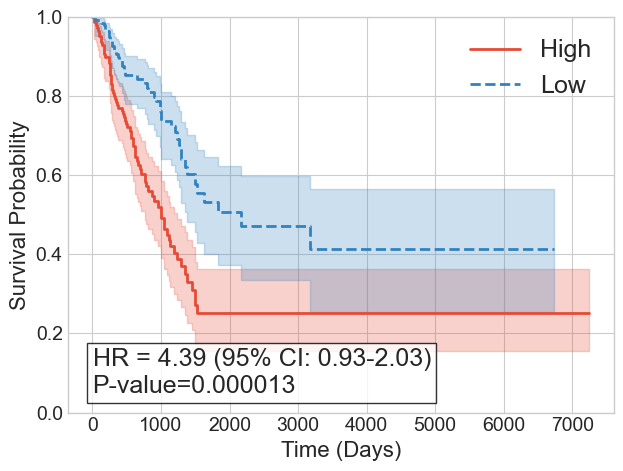

In [26]:
gsva = pd.read_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\data\\LUAD\\GSVA/GSVA_scores.csv')
gsva.index = gsva.iloc[:,0]
gsva = gsva.drop('Unnamed: 0',axis=1)
gsva = gsva.T
merged_data = pd.merge(gsva, clin_df, left_index=True, right_index=True)
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# upper quartile versus lower quartile
nes_values = merged_data['Prognostic_relevant_LR_gene']
upper_quartile = np.quantile(nes_values, 0.75)  
lower_quartile = np.quantile(nes_values, 0.25) 

high = merged_data[merged_data['Prognostic_relevant_LR_gene'] >= upper_quartile]
low = merged_data[merged_data['Prognostic_relevant_LR_gene'] <= lower_quartile]

results = logrank_test(
    high['OS.time'],        
    low['OS.time'],          
    event_observed_A=high['OS'],  
    event_observed_B=low['OS']    
) 

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})


high_color = "#E64B35"  
low_color = "#3182BD"  

kmf = KaplanMeierFitter()
kmf.fit(high['OS.time'], event_observed=high['OS'], label=f'High')
ax = kmf.plot(ci_show=True, color=high_color, linewidth=2)
kmf.fit(low['OS.time'], event_observed=low['OS'], label=f'Low')
kmf.plot(ax=ax, ci_show=True, color=low_color, linewidth=2, linestyle='--')

from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(merged_data[['Prognostic_relevant_LR_gene', 'OS.time', 'OS']], 
        duration_col='OS.time', event_col='OS', formula='Prognostic_relevant_LR_gene')
hr = cph.hazard_ratios_[0]
ci = cph.confidence_intervals_.values[0]

stats_text = f"HR = {hr:.2f} (95% CI: {ci[0]:.2f}-{ci[1]:.2f})\nP-value={results.p_value:.6f}"
plt.text(0.6, 0.05, stats_text, bbox=dict(facecolor='white', alpha=0.8), fontsize=18)

plt.xlabel("Time (Days)", fontsize=16) 
plt.ylabel("Survival Probability", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.legend(fontsize=18)
plt.ylim(0, 1) 
#plt.savefig('E:\\NMF\\pic\\fig4\\gsva.png')
plt.show()

In [10]:
adata = sc.read_h5ad("F:\\pythonproject\\Tensor\\Chunk_v2\\data\\LUAD\\LUAD2_umap_sub876.h5ad")

In [11]:
sc_lr_expr_df, sc_lr_expr_pairs = Chunk.filter_scRNAdata(res, adata, label = 'CellName')
print("Expression matrix shape:", sc_lr_expr_df.shape)
connectivities = Chunk.similarity2adjacent(adata, key='connectivities')
X = Chunk.calculate_correlation_matrix(lr_expr_df, sc_lr_expr_df)
time, event = Chunk.getCoxelement(clin_df)

Expression matrix shape: (84, 89887)


D:\python\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



|**************************************************|
Performing quality-check for the correlations
The five-number summary of correlations:
Min: -0.16806752231643537
25th Percentile: 0.4638839900776611
Median: 0.5477133827854774
75th Percentile: 0.6199589512327321
Max: 0.9258869577744384
|**************************************************|


In [225]:
CCcomm = Chunk.CCcommInfer(method="cox", X = X,time = time,event = event, alpha=0, lambda_=0.1, Omega=connectivities, learning_rate=0.001, n_epochs=1000)

Epoch [100/1000], Loss: 5.4509
Epoch [200/1000], Loss: 5.4270
Epoch [300/1000], Loss: 5.4157
Epoch [400/1000], Loss: 5.4097
Epoch [500/1000], Loss: 5.4062
Epoch [600/1000], Loss: 5.4038
Epoch [700/1000], Loss: 5.4020
Epoch [800/1000], Loss: 5.4004
Epoch [900/1000], Loss: 5.3991
Epoch [1000/1000], Loss: 5.3979


In [13]:
fontsize = 16
plt.rcParams.update({
    'font.size': fontsize,
    'axes.titlesize': fontsize,
    'axes.labelsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize
})

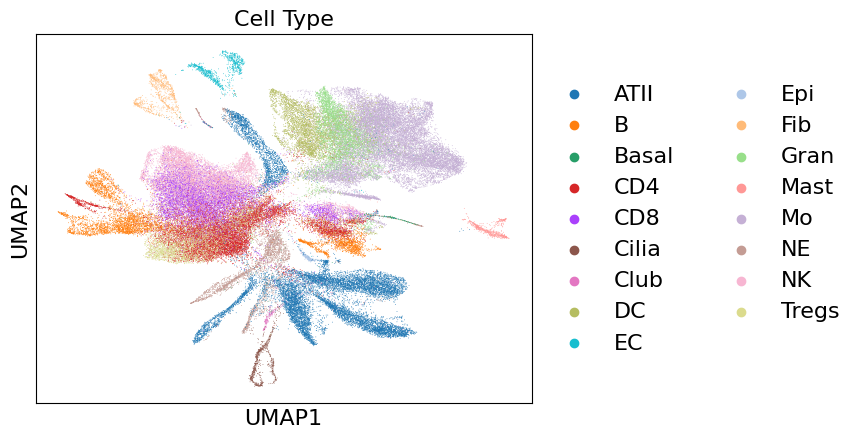

In [14]:
sc.pl.umap(adata, color='CellName',title='Cell Type', save='LUAD.png')#,legend_loc="on data"

Figure saved to: E:\NMF\pic\fig4\top40phe_LUAD.png


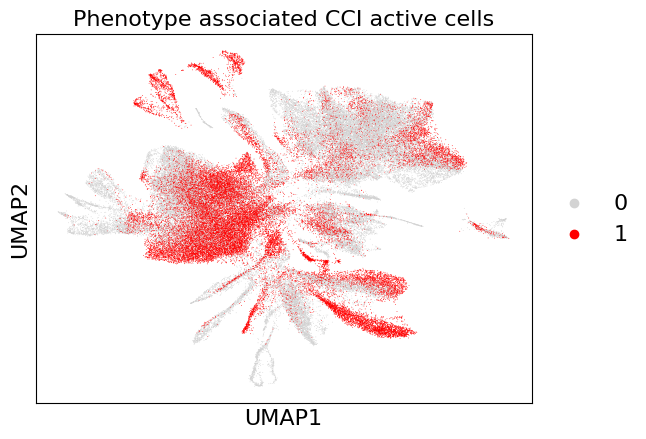

In [21]:
Chunk.getPosipotentialCCI(adata, CCcomm.model, threshold_percent = 60,savefig='E:\\NMF\\pic\\fig4\\top40phe_LUAD.png')# 

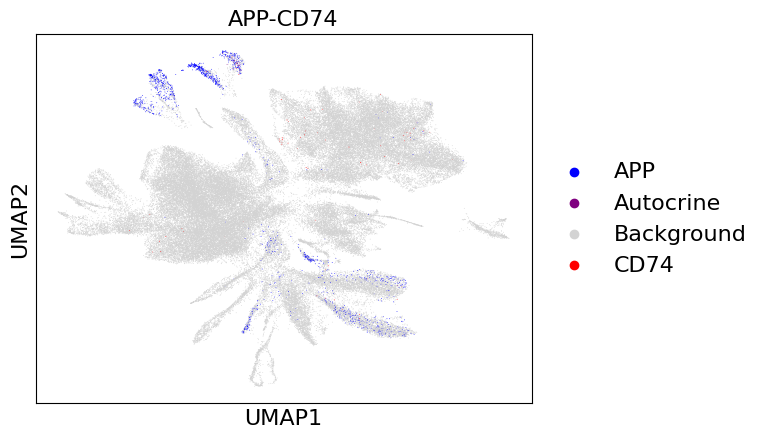

In [20]:
Chunk.getCCcomm(adata, 'APP', 'CD74', L_threshold=10, R_threshold=10, marked_col='phe_cell')

In [22]:
adata1 = adata[adata.obs['phe_cell'] == '1', :].copy()
adata1 = adata1[~adata1.obs['CellName'].isna(),:]
Allcell = np.unique(adata1.obs['CellName'].values).tolist()
adata2 = adata[adata.obs['phe_cell'] == '0', :].copy()
adata2 = adata2[~adata2.obs['CellName'].isna(),:]

In [23]:
interestcell = ['ATII', 'CD4', 'CD8', 'EC', 'Epi', 'Fib', 'Mast', 'Mo', 'NE', 'NK', 'Tregs']

In [53]:
pvalues, means, significant_means = Chunk.Cellphone(
        adata=adata1,
        celltype_key='CellName',
        interactions=res,
        iterations=1000,
        senders=interestcell,
        receivers=interestcell
    )

Running randomization analysis: 100%|██████████████████████████████████████████████| 1000/1000 [02:38<00:00,  6.33it/s]


D:\python\Lib\site-packages\PyComplexHeatmap\dotHeatmap.py:360: FutureWarning:

The provided callable <function mean at 0x0000014B7EACDD00> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.

D:\python\Lib\site-packages\PyComplexHeatmap\dotHeatmap.py:379: FutureWarning:

The provided callable <function mean at 0x0000014B7EACDD00> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.

D:\python\Lib\site-packages\PyComplexHeatmap\dotHeatmap.py:395: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

D:\python\Lib\site-packages\PyComplexHeatmap\dotHeatmap.py:409: FutureWarning:

The provided callable <function mean at 0x0000014B7EACDD00> is currently using DataFrameGroupBy.mean. In a future version of pandas, the pro

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 268.5698731099435
Plotting legends..
Estimated legend width: 14.465277777777779 mm


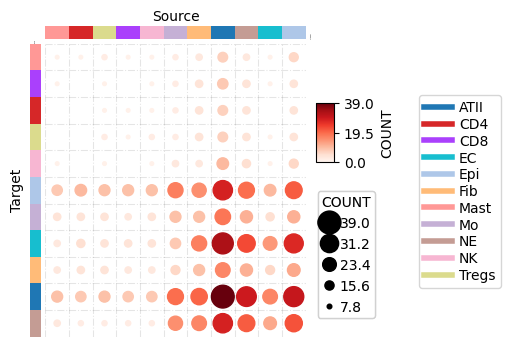

In [74]:
interaction_edges = Chunk.extract_interaction_edges(pvalues, alpha=0.05)
fig, ax = plt.subplots(figsize=(3.5,3.5)) 
Chunk.cpdb_heatmap(adata1[adata1.obs['CellName'].isin(interestcell),:],interaction_edges,celltype_key='CellName',
                   fontsize=10,
          ax=ax,legend_kws={'fontsize':10,'bbox_to_anchor':(5, -0.5),'loc':'center left',})
#plt.savefig('E:\\NMF\\pic\\fig4\\commheatmap_interestcell.png', dpi=300, bbox_inches='tight')
plt.show()

D:\python\Lib\site-packages\PyComplexHeatmap\dotHeatmap.py:360: FutureWarning:

The provided callable <function mean at 0x0000014B7EACDD00> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.

D:\python\Lib\site-packages\PyComplexHeatmap\dotHeatmap.py:379: FutureWarning:

The provided callable <function mean at 0x0000014B7EACDD00> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.

D:\python\Lib\site-packages\PyComplexHeatmap\dotHeatmap.py:395: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

D:\python\Lib\site-packages\PyComplexHeatmap\dotHeatmap.py:409: FutureWarning:

The provided callable <function mean at 0x0000014B7EACDD00> is currently using DataFrameGroupBy.mean. In a future version of pandas, the pro

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 57.1881942635084
Plotting legends..
Estimated legend width: 16.758333333333333 mm


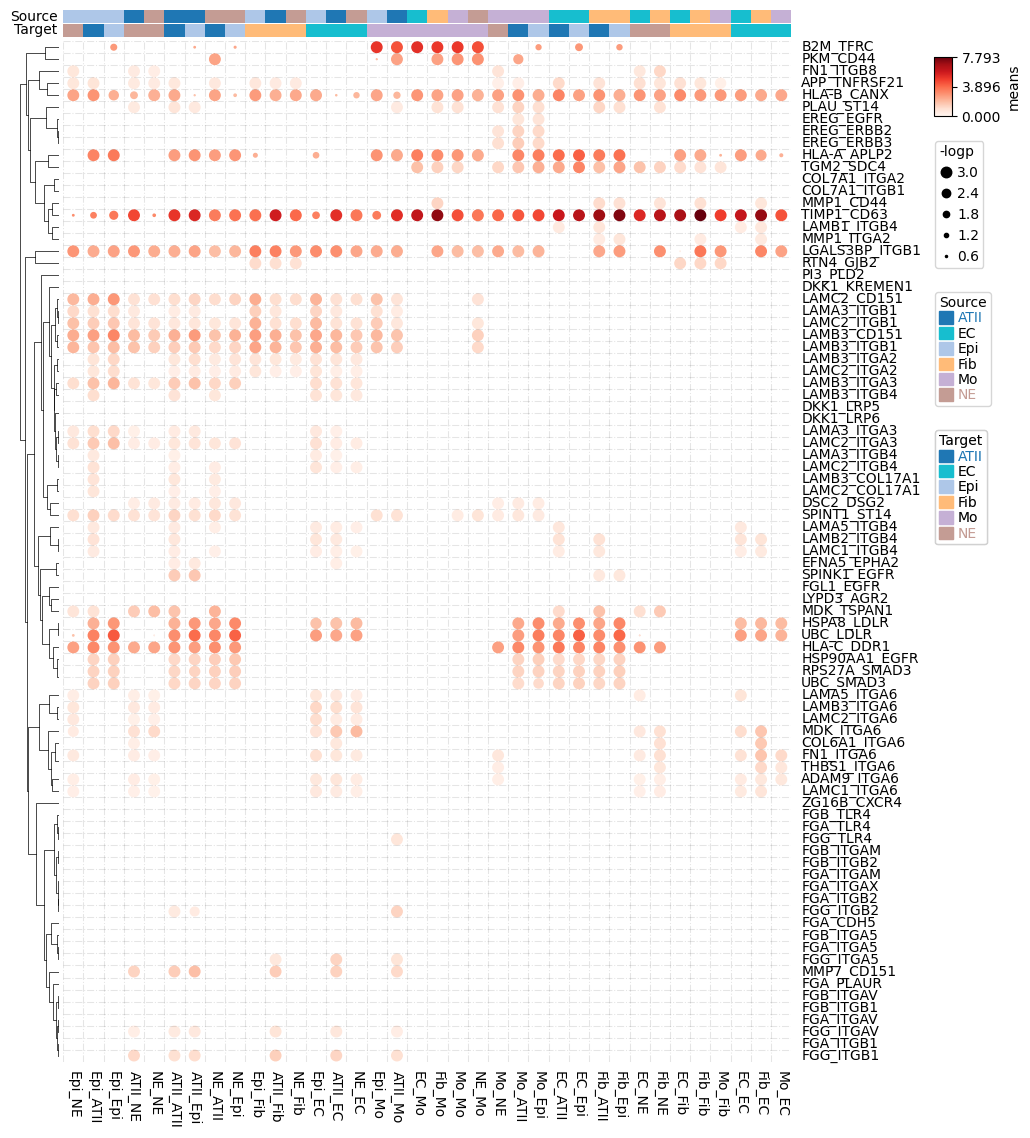

In [77]:
source_cells=['ATII', 'EC', 'Epi', 'Fib', 'Mo', 'NE']
target_cells=['ATII', 'EC', 'Epi', 'Fib', 'Mo', 'NE']
Chunk.cpdb_interacting_heatmap(adata=adata,
                            celltype_key='CellName',
                            means=means, 
                            pvalues=pvalues, 
                            source_cells=source_cells,
                            target_cells=target_cells,
                            min_means=1,
                            nodecolor_dict=None,
                            ax=None,
                            figsize=(10,12),
                            fontsize=10,)

plt.show()

D:\python\Lib\site-packages\PyComplexHeatmap\dotHeatmap.py:360: FutureWarning:

The provided callable <function mean at 0x0000014B7EACDD00> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.

D:\python\Lib\site-packages\PyComplexHeatmap\dotHeatmap.py:379: FutureWarning:

The provided callable <function mean at 0x0000014B7EACDD00> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.

D:\python\Lib\site-packages\PyComplexHeatmap\dotHeatmap.py:395: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

D:\python\Lib\site-packages\PyComplexHeatmap\dotHeatmap.py:409: FutureWarning:

The provided callable <function mean at 0x0000014B7EACDD00> is currently using DataFrameGroupBy.mean. In a future version of pandas, the pro

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 111.0413070555894
Plotting legends..
Estimated legend width: 16.758333333333333 mm


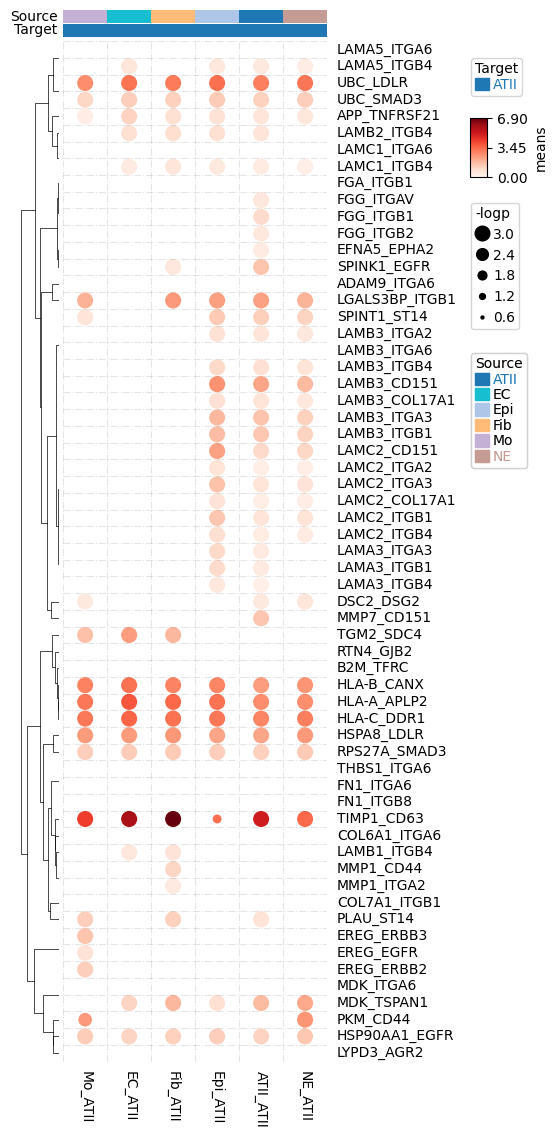

In [84]:
source_cells=['ATII', 'EC', 'Epi', 'Fib', 'Mo', 'NE']
target_cells=['ATII']
Chunk.cpdb_interacting_heatmap(adata=adata,
                            celltype_key='CellName',
                            means=means, 
                            pvalues=pvalues, 
                            source_cells=source_cells,
                            target_cells=target_cells,
                            min_means=1,
                            nodecolor_dict=None,
                            ax=None,
                            figsize=(4,12),
                            fontsize=10,)
#plt.savefig('E:\\NMF\\pic\\fig4\\interactheatmap_target_at2.png', dpi=300, bbox_inches='tight')
plt.show()

D:\python\Lib\site-packages\PyComplexHeatmap\dotHeatmap.py:360: FutureWarning:

The provided callable <function mean at 0x0000014B7EACDD00> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.

D:\python\Lib\site-packages\PyComplexHeatmap\dotHeatmap.py:379: FutureWarning:

The provided callable <function mean at 0x0000014B7EACDD00> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.

D:\python\Lib\site-packages\PyComplexHeatmap\dotHeatmap.py:395: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

D:\python\Lib\site-packages\PyComplexHeatmap\dotHeatmap.py:409: FutureWarning:

The provided callable <function mean at 0x0000014B7EACDD00> is currently using DataFrameGroupBy.mean. In a future version of pandas, the pro

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Inferred max_s (max size of scatter point) is: 77.5351292088287
Plotting legends..
Estimated legend width: 16.758333333333333 mm


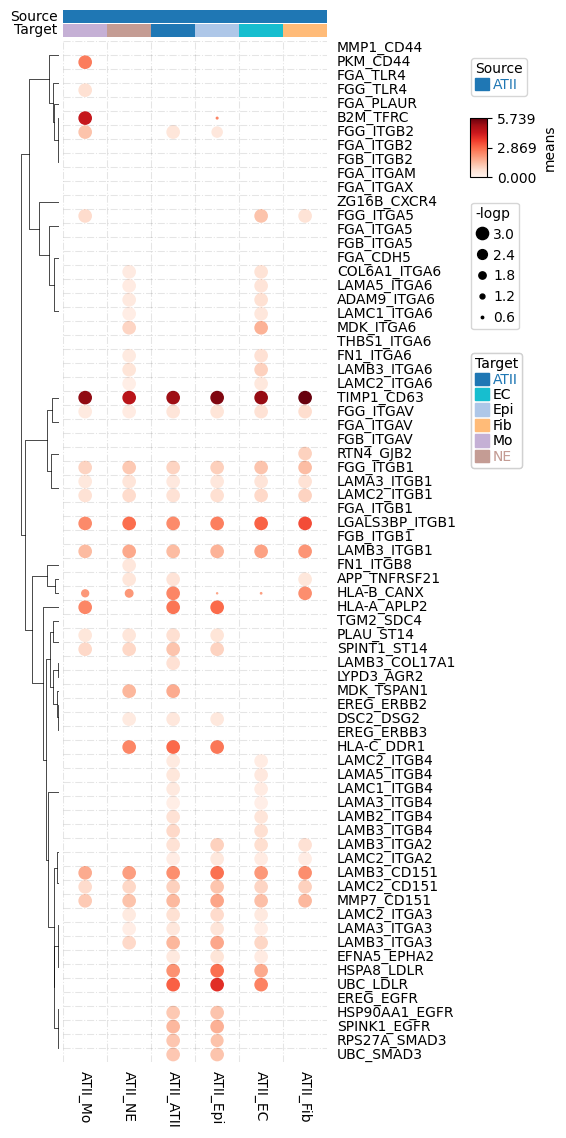

In [85]:
source_cells=['ATII']
target_cells=['ATII', 'EC', 'Epi', 'Fib', 'Mo', 'NE']
Chunk.cpdb_interacting_heatmap(adata=adata,
                            celltype_key='CellName',
                            means=means, 
                            pvalues=pvalues, 
                            source_cells=source_cells,
                            target_cells=target_cells,
                            min_means=1,
                            nodecolor_dict=None,
                            ax=None,
                            figsize=(4,12),
                            fontsize=10,)
#plt.savefig('E:\\NMF\\pic\\fig4\\interactheatmap_source_at2.png', dpi=300, bbox_inches='tight')
plt.show()

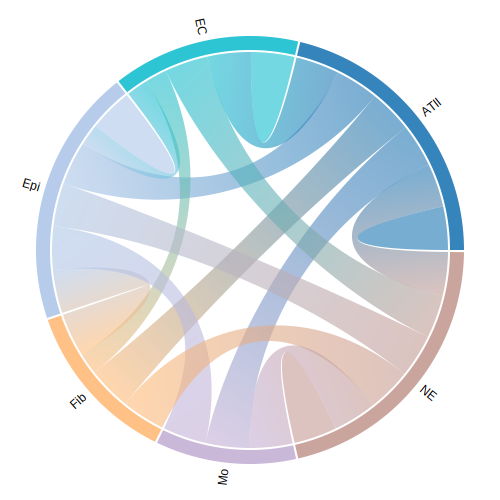

In [87]:
fig=Chunk.cpdb_chord(adata1,interaction_edges,celltype_key='CellName',
          count_min=10,fontsize=12,padding=50,radius=200,save=None,)
fig.show()

<AxesSubplot: >

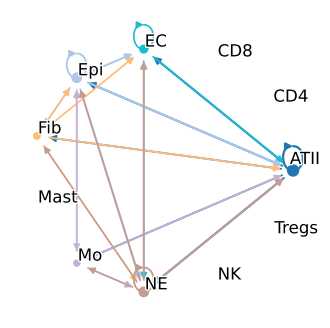

In [88]:
fig, ax = plt.subplots(figsize=(4,4)) 
Chunk.cpdb_network(adata1,interaction_edges,celltype_key='CellName',
             counts_min=10,
            nodesize_scale=5,
                  ax=ax)

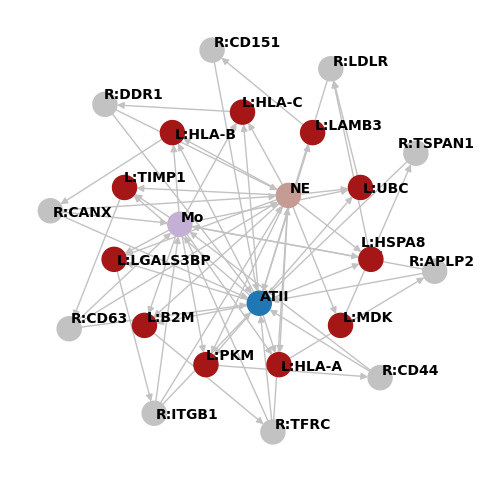

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
Chunk.cpdb_interacting_network(adata=adata,
                         celltype_key='CellName',
                            means=means,
                            source_cells=['NE','Mo','ATII'],
                            target_cells=['NE','Mo','ATII'],
                            means_min=2,
                             means_sum_min=2,        
                            fontsize=10,
                            ax=ax)
plt.show()